In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
np.random.SEED = 42

In [2]:
n_samples = 5 * np.ones(4, dtype=int)
dose = np.array([-0.86,-0.3,-.05,.73])
deaths = np.array([0,1,3,5])

In [3]:
def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

In [4]:
def p_posterior(alpha,beta,dose,obs_deaths,n):
    p = []
    for dose_i,obs_deaths_i,n_i in zip(dose,obs_deaths,n):
        theta_i = invlogit(alpha+beta*dose_i)
        p.append(theta_i**obs_deaths_i*(1-theta_i)**(n_i-obs_deaths_i))
    p = np.array(p)
    return np.prod(p,axis=0)
        

In [5]:
delta = 0.1
alpha = np.arange(-5.0,10+delta,delta)
beta = np.arange(-10,40+delta,delta)

ALPHA, BETA = np.meshgrid(alpha,beta)
p = p_posterior(ALPHA, BETA, dose, deaths, n_samples)

(0, 25)

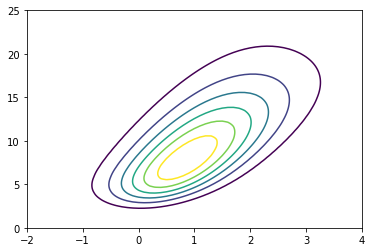

In [6]:
plt.figure()
CS = plt.contour(ALPHA,BETA,p)
plt.xlim((-2,4))
plt.ylim((0,25))

In [7]:
alpha_marg = np.mean(p,axis=0)
beta_marg = np.mean(p,axis=1)

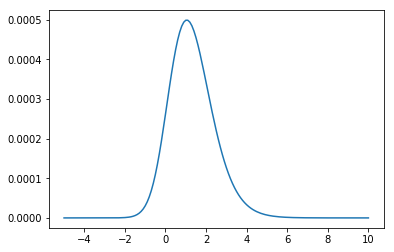

In [8]:
plt.plot(alpha,alpha_marg)

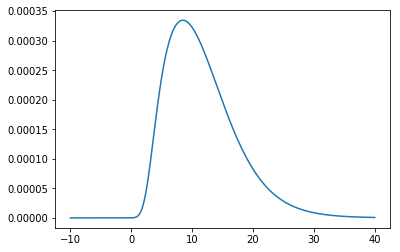

In [9]:
plt.plot(beta, beta_marg)

In [10]:
def inv_cdf(pdf,x):
    cdf = [integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf = np.array([0] + cdf)
    cdf = cdf / cdf[-1]
    return interpolate.interp1d(cdf,x)

In [11]:
n = 1000
sample_alpha = np.random.random_sample(n)
sample_beta = np.random.random_sample(n)

alpha_sample = inv_cdf(alpha_marg,alpha)(sample_alpha)

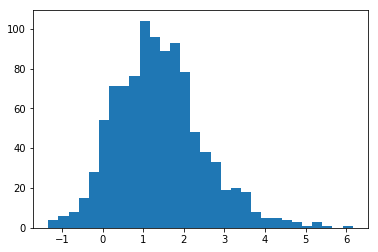

In [12]:
_ = plt.hist(alpha_sample,bins=30)

In [13]:
beta_sample = []

for alp,bet in zip(alpha_sample,sample_beta):
    bet_dis = p_posterior(alp,beta,dose,deaths,n_samples)
    b_sample = inv_cdf(bet_dis,beta)(bet)
    beta_sample.append(b_sample)

beta_sample = np.array(beta_sample)

(array([ 86., 251., 231., 181., 133.,  64.,  39.,   7.,   5.,   3.]),
 array([ 1.40685549,  4.9741954 ,  8.54153531, 12.10887522, 15.67621513,
        19.24355505, 22.81089496, 26.37823487, 29.94557478, 33.5129147 ,
        37.08025461]),
 <a list of 10 Patch objects>)

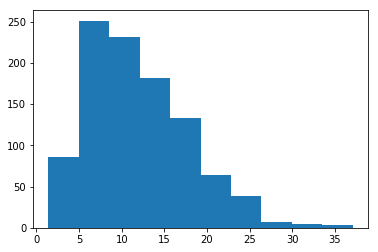

In [14]:
beta_sample = np.array(beta_sample)
plt.hist(beta_sample)

In [15]:
ld50 = -alpha_sample/beta_sample

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   5.,   3.,
         12.,  31.,  72., 109., 247., 254., 143.,  64.,  30.,  13.,   6.,
          4.,   2.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([-0.86619201, -0.81953361, -0.77287521, -0.7262168 , -0.6795584 ,
        -0.63289999, -0.58624159, -0.53958319, -0.49292478, -0.44626638,
        -0.39960798, -0.35294957, -0.30629117, -0.25963277, -0.21297436,
        -0.16631596, -0.11965756, -0.07299915, -0.02634075,  0.02031765,
         0.06697606,  0.11363446,  0.16029286,  0.20695127,  0.25360967,
         0.30026807,  0.34692648,  0.39358488,  0.44024328,  0.48690169,
         0.53356009]),
 <a list of 30 Patch objects>)

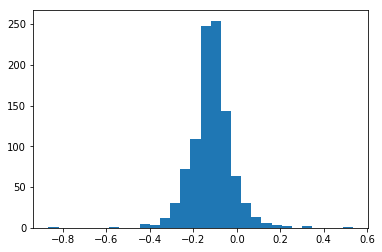

In [16]:
plt.hist(ld50,bins=30)

In [17]:
print(np.percentile(ld50,[2.5,25,50,75,97.5]))

[-0.29091968 -0.16365559 -0.11561243 -0.06917272  0.06943938]


In [24]:
n = 1000
proposal = np.random.multivariate_normal([0,0],[[1,0],[0,5]],n)

alpha_mc = 4.0
beta_mc = 42.0
p_mc = p_posterior(alpha_mc,beta_mc,dose,deaths,n_samples)

alpha_chain = [alpha_mc]
beta_chain = [beta_mc]

for dev_a,dev_b in proposal:
    alpha_proposal = alpha_mc + dev_a
    beta_proposal = beta_mc + dev_b
    p_proposal = p_posterior(alpha_proposal,beta_proposal,dose,deaths,n_samples)
    if (p_proposal>=p_mc) or (np.random.random()<p_proposal/p_mc):
        alpha_mc = alpha_proposal
        beta_mc = beta_proposal
        p_mc = p_proposal
    alpha_chain.append(alpha_mc)
    beta_chain.append(beta_mc)

    

In [25]:
alpha_chain = np.array(alpha_chain)
beta_chain = np.array(beta_chain)

In [26]:
ld50_mcmc = -alpha_chain/beta_chain

(array([0.13341722, 0.13341722, 0.        , 0.        , 0.08894481,
        0.13341722, 0.04447241, 0.04447241, 0.22236203, 0.35577926,
        0.44472407, 0.35577926, 1.11181017, 1.55653424, 2.84623405,
        4.53618551, 4.13593385, 6.44849901, 7.69372641, 5.95930253,
        3.29095812, 1.2452274 , 1.20075499, 1.42311702, 0.44472407,
        0.26683444, 0.17788963, 0.13341722, 0.        , 0.08894481]),
 array([-0.5087498 , -0.48628641, -0.46382302, -0.44135963, -0.41889624,
        -0.39643286, -0.37396947, -0.35150608, -0.32904269, -0.3065793 ,
        -0.28411591, -0.26165252, -0.23918913, -0.21672574, -0.19426235,
        -0.17179896, -0.14933557, -0.12687218, -0.10440879, -0.0819454 ,
        -0.05948201, -0.03701862, -0.01455523,  0.00790816,  0.03037154,
         0.05283493,  0.07529832,  0.09776171,  0.1202251 ,  0.14268849,
         0.16515188]),
 <a list of 30 Patch objects>)

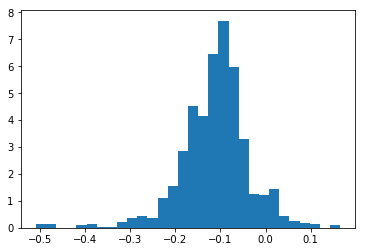

In [28]:
plt.hist(ld50_mcmc,bins=30,density=True)

In [36]:
print(np.percentile(ld50_mcmc[400:],[2.5,25,50,75,97.5]))

[-0.31260673 -0.15986343 -0.11643092 -0.0756525   0.02554453]


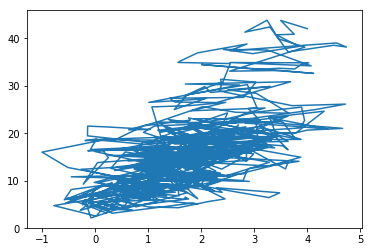

In [33]:
plt.plot(alpha_chain,beta_chain)